In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")#消除警告


class Bayes_Classifier(object):
    '''贝叶斯分类器'''
    
    def __init__(self):
        '''定义训练集'''
        self.X_train = None
        self.y_train = None
        
        
        
    def fit(self,X_train,y_train):
        #   给训练集赋值
        self.X_train = X_train
        self.y_train = y_train

    def cal_base_rates(self):
        '''
        计算先验概率
        data为训练集
        '''
        cal_base_rates = {}
        labels = self.Get_Decision_attribute()        
        #计算先验概率
        for label in labels:
            #如 :  '是'在y_train_data中出现的次数 / 在y_train_data的长度
            priori_prob = sum(self.y_train == label) / len(self.y_train)
            #放入字典中
            cal_base_rates[label] = priori_prob
        
        return cal_base_rates    
    
    def Get_Decision_attribute(self):
        '''获得数据集的决策属性'''
        labels = set(self.y_train)
        
        return labels
    

    def Conditional_Probability(self,X_test):
        '''
        为每个属性估计条件概率,data为待预测数据
        return {'好瓜':{'青绿': 0.375}}
        X_train_data,y_train_data为训练集
        X_test like:['青绿', '蜷缩', '浊响', '清晰', '凹陷', '硬滑', 0.697, 0.46]
        '''
        
        labels = self.Get_Decision_attribute()
        #统计不同类别的个数,如{'好' : 3,'坏':8}
        labels_count = {}
         #存放好瓜,坏瓜的编号,like ：{’好': [[2],[4],[10]],'坏' : [...]}
        labels_place = {}
        #  存放后验概率
        cal_base_rates = {}
    
        for label in labels:
            labels_count[label] = sum(self.y_train == label)
             #记录好瓜,坏瓜的编号
            labels_place[label] = np.argwhere(self.y_train == label)
            cal_base_rates[label] = []#  初始化
            
        flag = 0
        #计算每个属性的条件概率
        for value in X_test:            
            #对连续值的处理
            if type(value) != str:                
                for label,places in labels_place.items():#
                    int_value = []#如：存放好瓜的密度
                    for place in places:
                        int_value.append(self.X_train[place,flag])#将取值放入,方便等会计算均值，标准差
                    #  计算均值，标准差
                    value_mean = np.mean(int_value)
                    value_std = np.std(int_value)                    
                    #高斯模型
                    race = (np.exp(((value - value_mean) ** 2) / (-2 * (value_std ** 2)))) / (np.sqrt(2 * np.pi) * value_std)
                    cal_base_rates[label].append(race)
                
            #   对离散值的处理
            else:                
                for label,places in labels_place.items():#
                    value_count = 0#  用来统计某个元素的个数: 如'青绿' 3 次，那么value_count = 3
                    for place in places:
                        if value == self.X_train[place,flag]:
                            value_count += 1
                    #计算概率
                    race = value_count / len(places) #places的个数即好瓜的个数 or 坏瓜
                    #  这里不加标记是那个取值的概率，是因为后面都是直接乘积
                    cal_base_rates[label].append(race)#  like: {'好' :[0.357,0.625,...]}
            
            flag = flag + 1         
        
        return cal_base_rates


    def Predict(self,X_test):
        '''
        给出一条数据的预测结果,
        X_test like:['青绿', '蜷缩', '浊响', '清晰', '凹陷', '硬滑', 0.697, 0.46] 
        '''
        from functools import reduce        
        
        #   得出先验概率和后验概率
        result_behind = self.Conditional_Probability(X_test)
        result_before = self.cal_base_rates()
        #  计算概率
        max_race = 0
        flag = None
        for label,value in result_behind.items():
            
            race = reduce(lambda x,y:x * y,value) * result_before[label]   #  计算概率
            
            if max_race < race:  
                max_race = race
                flag = label
        
        return flag   #   返回类别

    def Score_model(self,X_test,y_test):
        '''
        返回测试集精度
        给出一组数据的精度结果,
        X_test like:
        ['青绿', '稍蜷', '浊响', '稍糊', '凹陷', '硬滑', 0.639, 0.161],
       ['青绿', '蜷缩', '浊响', '清晰', '凹陷', '硬滑', 0.6970000000000001, 0.46],
       ['青绿', '蜷缩', '沉闷', '清晰', '凹陷', '硬滑', 0.608, 0.318]......
        '''
        
        y_pred = []
        for item in X_test:
            result = self.Predict(item)
            y_pred.append(result)
        
        return np.mean(y_pred == y_test)
        
    #  考虑到该模型精度波动大，我们做十次去均值
    '''
    def Mean_of_model(data,cv = 10):
        #data为数据集
        score = []
        for i in range(cv):
            X_train,X_test,y_train,y_test = train_test_split(data[:,:-1],data[:,-1],test_size = 0.3)
            score.append(Score_model(X_train,y_train,X_test,y_test))
        
        return np.mean(score)
    '''

In [5]:
data = pd.read_csv('xig.csv')
data.drop(columns = '编号',inplace = True)
data_np = np.array(data)
print(data_np[:5,:])
#划分数据,data_np[:,-1]为决策属性列
X_train,X_test,y_train,y_test = train_test_split(data_np[:,:-1],data_np[:,-1],\
                            test_size = 0.3)

test = ['青绿','蜷缩','浊响','清晰','凹陷','硬滑',0.697,0.460]

#  建立模型
bayes = Bayes_Classifier()
#  训练模型
bayes.fit(X_train,y_train)

print("Test set score: {:.2f}".format(bayes.Score_model(X_test,y_test)))
 



[['青绿' '蜷缩' '浊响' '清晰' '凹陷' '硬滑' 0.697 0.46 '是']
 ['乌黑' '蜷缩' '沉闷' '清晰' '凹陷' '硬滑' 0.774 0.376 '是']
 ['乌黑' '蜷缩' '浊响' '清晰' '凹陷' '硬滑' 0.634 0.264 '是']
 ['青绿' '蜷缩' '沉闷' '清晰' '凹陷' '硬滑' 0.608 0.318 '是']
 ['浅白' '蜷缩' '浊响' '清晰' '凹陷' '硬滑' 0.556 0.215 '是']]
Test set score: 0.50


In [6]:
#  给出对test的预测结果
y_pred = bayes.Predict(test)
print("{} 的分类结果 {} 好瓜".format(test,y_pred))

['青绿', '蜷缩', '浊响', '清晰', '凹陷', '硬滑', 0.697, 0.46] 的分类结果 是 好瓜


In [7]:
bayes.fit(data_np[:,:-1],data_np[:,-1])
y_pred = bayes.Predict(test)

print("{} 的分类结果 {} 好瓜".format(test,y_pred))
  


['青绿', '蜷缩', '浊响', '清晰', '凹陷', '硬滑', 0.697, 0.46] 的分类结果 是 好瓜


In [8]:
#  用十次留出法的均值来评估模型
cv = 50
scores = []
for i in range(cv):    
    X_train,X_test,y_train,y_test = train_test_split(data_np[:,:-1],data_np[:,-1],\
                            test_size = 0.3)
    bayes = Bayes_Classifier()
    bayes.fit(X_train,y_train)
    scores.append(bayes.Score_model(X_test,y_test))

print("用{}次留出法的均值来评估模型 :{:.2f}".format(cv,np.mean(scores)))

用50次留出法的均值来评估模型 :0.47


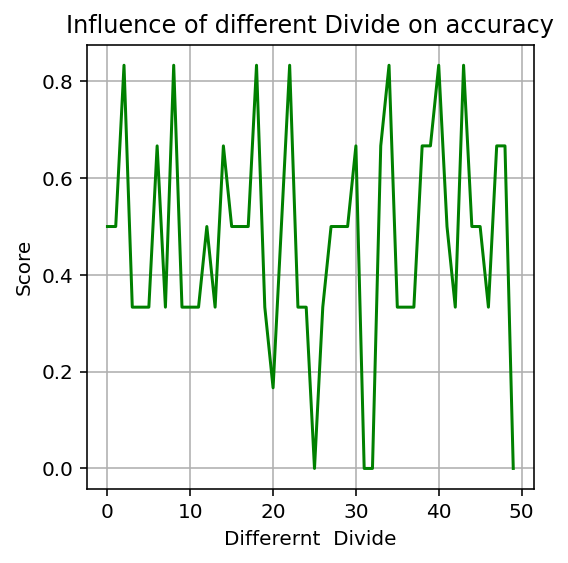

In [9]:
#   画图
import matplotlib.pyplot as plt
#    不同的划分对模型的影响
plt.figure(figsize = (4,4),dpi = 144)
plt.grid()
plt.plot(range(cv),scores,'g-')
plt.xlabel('Differernt  Divide')
plt.ylabel('Score')
plt.title('Influence of different Divide on accuracy')
plt.show()

In [6]:


from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd

data = pd.read_csv('xig.csv')
data.drop(columns = '编号',inplace = True)
label = LabelEncoder() 
for col in data[data.columns[:6]]:
    data[col] = label.fit_transform(data[col])
data

,色泽,根蒂,敲声,纹理,脐部,触感,密度,含糖率,好瓜
0,2,2,1,1,0,0,0.697,0.460,是
1,0,2,0,1,0,0,0.774,0.376,是
2,0,2,1,1,0,0,0.634,0.264,是
3,2,2,0,1,0,0,0.608,0.318,是
4,1,2,1,1,0,0,0.556,0.215,是
5,2,1,1,1,2,1,0.403,0.237,是
6,0,1,1,2,2,1,0.481,0.149,是
7,0,1,1,1,2,0,0.437,0.211,是
8,0,1,0,2,2,0,0.666,0.091,否
9,2,0,2,1,1,1,0.243,0.267,否
